## What this project does?

This project builds a text classification system that automatically assigns a news category to an article based on its content.

Given a raw article, the system predicts one of the BBC news categories:

Business

Politics

Sport

Technology

Entertainment

In [1]:
import numpy as np
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding,
    LSTM,
    Bidirectional,
    Dense,
    Dropout
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

2026-01-09 09:36:17.843302: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767951378.036217      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767951378.090757      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767951378.549632      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767951378.549681      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767951378.549683      24 computation_placer.cc:177] computation placer alr

In [2]:
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import random
import numpy as np
import tensorflow as tf
import os

SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## 📂 Load the Dataset

We now load the BBC News dataset from Kaggle.

This dataset is already well-structured, so we expect:

* One column with article text

* One column with category labels

In [4]:
# Load the BBC News dataset
df = pd.read_csv("/kaggle/input/bbc-news/bbc-text.csv")

In [5]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


## Text Processing

In [6]:
# Download required NLTK resources
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
# Initialize English stopwords
stop_words = set(stopwords.words("english"))

In [8]:
len(stop_words)

198

## Tokenization & Padding

In [9]:
def clean_text(text):
    # Lowercase
    text = text.lower()
    
    # Remove punctuation
    text = re.sub(f"[{string.punctuation}]", " ", text)
    
    # Remove numbers
    text = re.sub(r"\d+", " ", text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # Rejoin
    return " ".join(tokens)


In [10]:
type(clean_text)

function

In [11]:
df["clean_text"] = df["text"].apply(clean_text)

In [12]:
df.columns

Index(['category', 'text', 'clean_text'], dtype='object')

In [13]:
MAX_VOCAB_SIZE = 20000

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df["clean_text"])
sequences = tokenizer.texts_to_sequences(df["clean_text"])

X = pad_sequences(
    sequences,
    maxlen=300,
    padding="post",
    truncating="post"
)

X.shape

(2225, 300)

In [14]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["category"])

num_classes = len(label_encoder.classes_)

## Splitting the data

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [16]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1780, 300) (445, 300)
(1780,) (445,)


## Building the model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

model = Sequential([
    Embedding(
        input_dim=MAX_VOCAB_SIZE,
        output_dim=200
    ),
    Bidirectional(
        LSTM(
            128,
            dropout=0.2,
            recurrent_dropout=0.2
        )
    ),
    Dense(num_classes, activation="softmax")
])

I0000 00:00:1767951394.316892      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [18]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True
)

## Training the BILTSM model

In [20]:
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.3121 - loss: 1.5303 - val_accuracy: 0.4719 - val_loss: 1.1723
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.6450 - loss: 0.9840 - val_accuracy: 0.9045 - val_loss: 0.4599
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.9222 - loss: 0.3815 - val_accuracy: 0.9551 - val_loss: 0.2432
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9799 - loss: 0.1153 - val_accuracy: 0.9635 - val_loss: 0.1038
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.9909 - loss: 0.0479 - val_accuracy: 0.9663 - val_loss: 0.1239
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9976 - loss: 0.0213 - val_accuracy: 0.9635 - val_loss: 0.1423


In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 300, 200)       │     4,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       336,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,014,545 (49.65 MB)

 Trainable params: 4,338,181 (16.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,676,364 (33.10 MB)

In [22]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print("Test accuracy:", test_accuracy)
print("Test loss:", test_loss)

Test accuracy: 0.9595505595207214
Test loss: 0.1339200884103775


In [23]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

print(
    classification_report(
        y_test,
        y_pred_classes,
        target_names=label_encoder.classes_
    )
)

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 254ms/step
               precision    recall  f1-score   support

     business       0.98      0.94      0.96       102
entertainment       0.89      1.00      0.94        77
     politics       0.95      0.93      0.94        84
        sport       0.98      0.99      0.99       102
         tech       1.00      0.94      0.97        80

     accuracy                           0.96       445
    macro avg       0.96      0.96      0.96       445
 weighted avg       0.96      0.96      0.96       445



In [24]:
model.save("bbc_bilstm_model.keras")

## Importing TF-IDF

In [25]:
# Import TF-IDF vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Import classical ML models
from sklearn.svm import LinearSVC

# Train-test split
from sklearn.model_selection import train_test_split

# Evaluation
from sklearn.metrics import classification_report, accuracy_score

In [26]:
# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    stop_words="english"
)

# Fit TF-IDF on cleaned text and transform it
X_tfidf = tfidf.fit_transform(df["clean_text"])

# Encode labels (reuse what you already did)
y = label_encoder.transform(df["category"])

X_tfidf.shape

(2225, 20000)

In [27]:
from sklearn.model_selection import train_test_split

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [28]:
# Initialize Linear SVM
svm_model = LinearSVC(random_state=42)

# Train the model
svm_model.fit(X_train_tfidf, y_train_tfidf)

LinearSVC(random_state=42)

In [29]:
from sklearn.metrics import classification_report, accuracy_score

y_pred_svm = svm_model.predict(X_test_tfidf)

print(
    classification_report(
        y_test_tfidf,
        y_pred_svm,
        target_names=label_encoder.classes_
    )
)

print("Accuracy:", accuracy_score(y_test_tfidf, y_pred_svm))

               precision    recall  f1-score   support

     business       0.97      0.99      0.98       102
entertainment       0.97      1.00      0.99        77
     politics       0.99      0.99      0.99        84
        sport       1.00      1.00      1.00       102
         tech       1.00      0.95      0.97        80

     accuracy                           0.99       445
    macro avg       0.99      0.99      0.99       445
 weighted avg       0.99      0.99      0.99       445

Accuracy: 0.9865168539325843


In [30]:
# Save TF-IDF + SVM pipeline components
import joblib

joblib.dump(tfidf, "tfidf_vectorizer.joblib")
joblib.dump(svm_model, "svm_tfidf_model.joblib")
joblib.dump(label_encoder, "label_encoder.joblib")

['label_encoder.joblib']

In [31]:
from sklearn.metrics import classification_report
import pandas as pd

# Generate classification report as dict
report_dict = classification_report(
    y_test_tfidf,
    y_pred_svm,
    target_names=label_encoder.classes_,
    output_dict=True
)

# Convert to DataFrame
report_df = pd.DataFrame(report_dict).transpose()
report_df

,precision,recall,f1-score,support
business,0.971154,0.990196,0.980583,102.000000
entertainment,0.974684,1.000000,0.987179,77.000000
politics,0.988095,0.988095,0.988095,84.000000
sport,1.000000,1.000000,1.000000,102.000000
tech,1.000000,0.950000,0.974359,80.000000
accuracy,0.986517,0.986517,0.986517,0.986517
macro avg,0.986787,0.985658,0.986043,445.000000
weighted avg,0.986760,0.986517,0.986474,445.000000


In [32]:
# Save classification report
report_df.to_csv("svm_tfidf_classification_report.csv")

# Save accuracy separately
accuracy_df = pd.DataFrame({
    "model": ["TF-IDF + LinearSVM"],
    "accuracy": [accuracy_score(y_test_tfidf, y_pred_svm)]
})

accuracy_df.to_csv("svm_tfidf_accuracy.csv", index=False)

## Comparing between the two approaches

In [33]:
import pandas as pd

comparison_df = pd.DataFrame({
    "Model": ["Bi-LSTM", "TF-IDF + Linear SVM"],
    "Accuracy": [
        0.96,  # From your Bi-LSTM evaluation
        accuracy_score(y_test_tfidf, y_pred_svm)
    ]
})

comparison_df

,Model,Accuracy
0,Bi-LSTM,0.960000
1,TF-IDF + Linear SVM,0.986517


/tmp/ipykernel_24/493419351.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


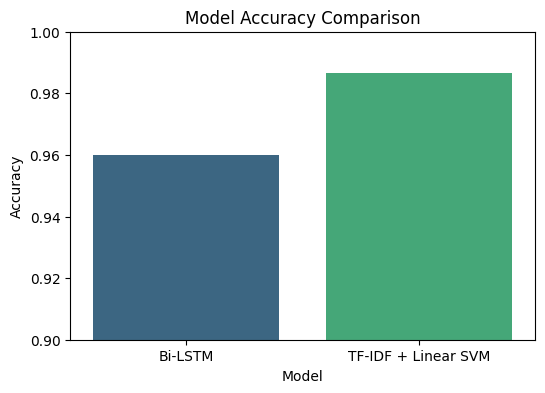

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.barplot(
    data=comparison_df,
    x="Model",
    y="Accuracy",
    palette="viridis"
)

plt.ylim(0.9, 1.0)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.show()

In [35]:
from sklearn.metrics import accuracy_score

# Bi-LSTM accuracy
bilstm_test_accuracy = accuracy_score(
    y_test,
    model.predict(X_test).argmax(axis=1)
)

# TF-IDF + SVM accuracy
svm_test_accuracy = accuracy_score(
    y_test_tfidf,
    y_pred_svm
)

print("Final Test Accuracy Comparison")
print("-" * 35)
print(f"Bi-LSTM Accuracy        : {bilstm_test_accuracy:.4f}")
print(f"TF-IDF + SVM Accuracy   : {svm_test_accuracy:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step
Final Test Accuracy Comparison
-----------------------------------
Bi-LSTM Accuracy        : 0.9596
TF-IDF + SVM Accuracy   : 0.9865
